## Simulate The Two Stock Paths Using Multivariate


Simulate the stock prices which we will use later on to estimate the parameters of the multivariate heston model


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from matplotlib import style
from scipy.optimize import NonlinearConstraint
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import plotly.graph_objs as go

In [4]:
np.random.seed(2024)
# Our initial guess of the parameters
True_params = np.array([0.03, 0.03, 3, 3, 0.02, 0.02, 0.1, 0.1, 0.3, -0.3, 0.2])

mu    = np.array([0.03, 0.03])
kappa = np.array([3, 3])
theta = np.array([0.02, 0.02])
xi    = np.array([0.1, 0.1])
rho_sv1 = 0.3
rho_sv2 = -0.3
rho_ss  = 0.2


T = 1                           # Time horizon, say one year
n = 365                         # Number of time steps, divide the time horizon n times (These are trading days)
dt = T / n                      # Time increment

# Initialize variables
S = np.zeros((2, n+1))          # Stock prices, to store the two stock prices
V = np.zeros((2, n+1))          # Volatilities, to store the two volatilities

# Our initial guess of stock prices and volatilities
S[:, 0] = [100, 100]            # Initial stock prices
V[:, 0] = [0.2, 0.2]            # Initial volatilities

# Generate independent standard normal random variables (uncorrelated)
Z = np.random.randn(4, n)

# Calculate correlation matrix
corr_matrix = np.array([[1       , rho_ss  , rho_sv1,  0     ],
                        [rho_ss  , 1       , 0      , rho_sv2],
                        [rho_sv1 , 0       , 1      , 0      ],
                        [0       , rho_sv2 , 0      , 1     ]])

# Generate correlated random variables using the correlation matrix
C = np.linalg.cholesky(corr_matrix) # to obtain the lower traingular of the correlation matrix
Z_correlated = np.dot(C, Z)         # getting a vector of elements correlated using our corr_matrix

# Simulate stock prices and volatilities, making use of Euler discretisation.
for i in range(n):
    dS = mu * S[:, i] * dt + np.sqrt(V[:, i]) * S[:, i] * np.sqrt(dt) * Z_correlated[1:3, i]         # Change in price
    dV = kappa * (theta - V[:, i]) * dt + xi * np.sqrt(V[:, i]) * np.sqrt(dt) * Z_correlated[3:, i]  # Change in volatility

    S[:, i+1] = S[:, i] + dS
    V[:, i+1] = V[:, i] + dV


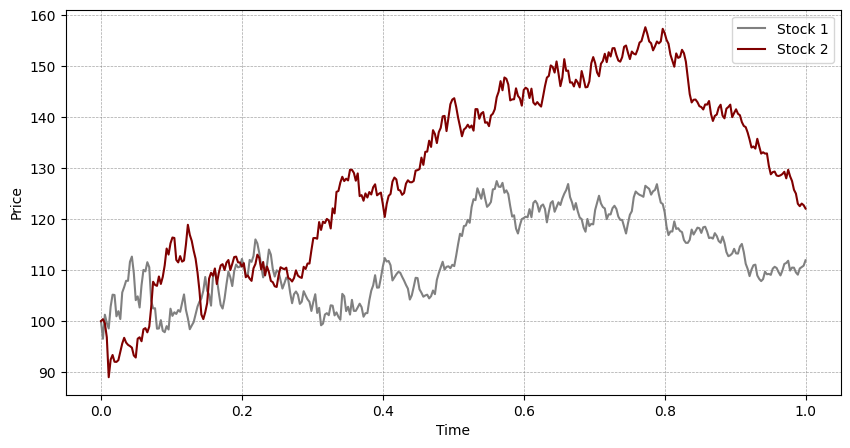

In [5]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 5))

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

ax.plot(np.linspace(0, T, n+1), S[0], label='Stock 1', color='grey')
ax.plot(np.linspace(0, T, n+1), S[1], label='Stock 2', color='maroon')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')

ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'grey', alpha = 0.7)
plt.savefig("theTwoStocks.png", bbox_inches='tight')
plt.show()

## Simulate Future Stock Prices

In [6]:
# The Prices for both stocks at T = 1
S1 = S[0, -1]
S2 = S[1, -1]

In [7]:
num_simulations = 1            # Number of simulations
num_prices      = 100          # Number of Paths to Simulate for each stock
np.random.seed(10)
# Initialize matrices to store the simulated prices after T = 1
S1_sim = np.zeros((num_simulations, num_prices, n+1))
S2_sim = np.zeros((num_simulations, num_prices, n+1))

# Initialize variables
SSim = np.zeros((num_prices, n+1, 2))  # Stock prices, to store the two stock prices
VSim = np.zeros((num_prices, n+1, 2))  # Volatilities, to store the two volatilities

# Our initial guess of stock prices and volatilities
SSim[:, 0, 0] = np.tile(S1.flatten(), num_prices)  # Assign initial prices for the first stock
SSim[:, 0, 1] = np.tile(S2.flatten(), num_prices)  # Assign initial prices for the second stock
VSim[:, 0, :] = [0.02, 0.02]                                       # Initial volatilities

# Generate independent standard normal random variables (uncorrelated)
Z = np.random.randn(n, 4, num_prices)  # Transposed Z

# Generate correlated random variables using the correlation matrix
C = np.linalg.cholesky(corr_matrix)  # Cholesky decomposition of correlation matrix
Z_correlated = np.matmul(C, Z)       # Matrix multiplication to get correlated random variables

# Simulate the prices
for sim in range(num_simulations):
    # Simulate stock prices and volatilities, making use of Euler discretisation.
    for i in range(n):
        # print("Wait :) - it's coming", i)  # Print time step, let's see if my code is running
        dS = mu * SSim[:, i, :] * dt + np.sqrt(VSim[:, i, :]) * SSim[:, i, :] * np.sqrt(dt) * Z_correlated[i, 1:3, :].T  # Transpose Z_correlated
        dV = kappa * (theta - VSim[:, i, :]) * dt + xi * np.sqrt(VSim[:, i, :]) * np.sqrt(dt) * Z_correlated[i, 3:, :].T  # Transpose Z_correlated

        SSim[:, i+1, :] = SSim[:, i, :] + dS
        VSim[:, i+1, :] = VSim[:, i, :] + dV
    S2_sim[sim] = SSim[:, :, 1]
    S1_sim[sim] = SSim[:, :, 0]  # Only storing the stock prices, not the volatilities


##### Plotting The Simulated Prices After T = 1

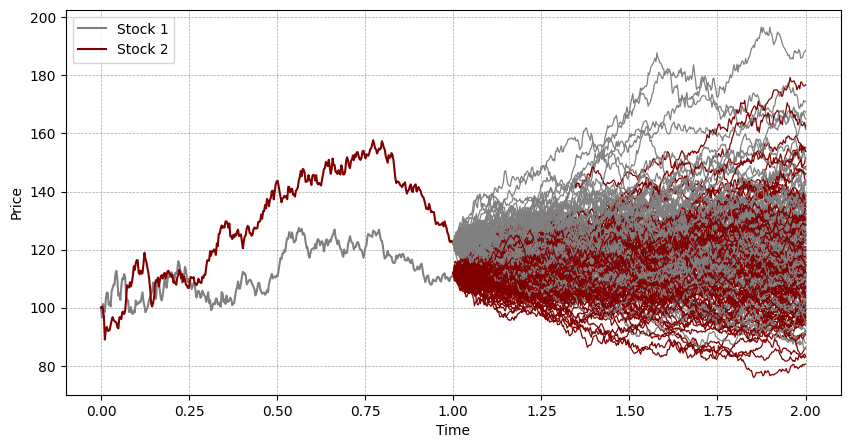

In [8]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 5))

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

T2 = 2
ax.plot(np.linspace(0, T, n+1), S[0], label='Stock 1', color='grey')
ax.plot(np.linspace(0, T, n+1), S[1], label='Stock 2', color='maroon')

for sim in range(num_simulations):
    for i in range(num_prices):
        ax.plot(np.linspace(1, T2, n+1), S2_sim[sim, i], color = 'grey', linewidth = 0.9)  # Simulated Stock 2
        ax.plot(np.linspace(1, T2, n+1), S1_sim[sim, i], color = 'maroon', linewidth = 0.9)  # Simulated Stock 1

ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend()

ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'grey', alpha = 0.7)
plt.savefig("stock_prices_simulation.png", bbox_inches='tight')
plt.show()


##### Histogram of the Payoffs

In [9]:
# The simulated stock prices at T = 2 for both stocks
S1_T2      = S1_sim[:, :, -1]
S2_T2      = S2_sim[:, :, -1]
difference = S1_T2[0] - S2_T2[0]         # Difference between the two stock at T = 2
payoffs    = np.maximum(difference, 0)   # Payoffs for Party II

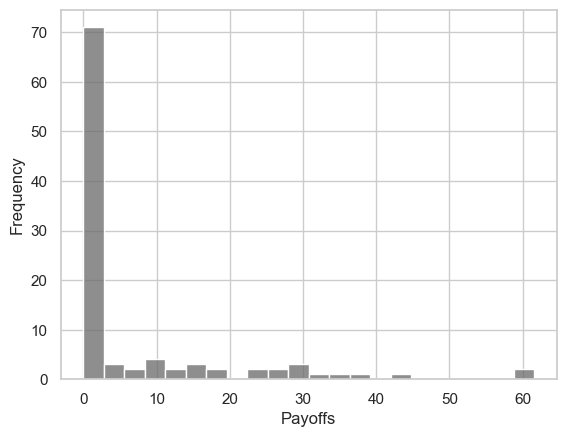

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt  

sns.set(style="whitegrid")  
hist_plot = sns.histplot(payoffs, color="dimgray") 
hist_plot.set(xlabel='Payoffs', ylabel='Frequency')
plt.savefig("payoffs.png", bbox_inches='tight')
plt.show()

In [11]:
s1 = np.linspace(np.min(S1_T2[0]), np.max(S1_T2[0]), 500)
s2 = np.linspace(np.min(S2_T2[0]), np.max(S2_T2[0]), 500)

ST1, ST2 = np.meshgrid(s1, s2)
difference = ST1 - ST2
payoffs    = np.maximum(difference, 0)

In [18]:
# Define s1 and s2
s1 = np.linspace(np.min(S1_T2[0]), np.max(S1_T2[0]), 500)
s2 = np.linspace(np.min(S2_T2[0]), np.max(S2_T2[0]), 500)

ST1, ST2 = np.meshgrid(s1, s2)
difference = ST1 - ST2
payoffs = np.maximum(difference, 0)

fig = plt.figure(figsize=(10, 10))
contours = go.Contour(x=ST1.flatten(), y=ST2.flatten(), z=payoffs.flatten(), colorscale='Greys')
surface = go.Surface(x=ST1, y=ST2, z=payoffs, colorscale='Greys')
layout = go.Layout(scene=dict(xaxis=dict(title = 'S1'),yaxis=dict(title = 'S2'),zaxis=dict(title='Payoffs')))
fig = go.Figure(data=[surface], layout=layout)
fig.write_html("PayoffSurface.html")


<Figure size 1000x1000 with 0 Axes>